In [63]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

# The trial solution using the deep neural network:
def g_trial(x,params, g0 = 10):
    return g0 + x*neural_network(params,x)

# The right side of the ODE:
def g(x, g_trial, gamma = 2):
    # return gamma*g_trial
    return 2 * x

# The cost function:
def cost_function(P, x):
    # Evaluate the trial function with the current parameters P
    g_t = g_trial(x,P)

    # Find the derivative w.r.t x of the trial function
    d_g_t = elementwise_grad(g_trial,0)(x,P)
    
    # The right side of the ODE
    func = g(x, g_t)

    err_sqr = (d_g_t - func)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum / np.size(err_sqr)

def g_analytic(x, gamma = 2, g0 = 10):
    # return g0*np.exp(gamma*x)
    return g0 + x**2


In [64]:
# Assuming one input, hidden, and output layer
def neural_network(params, x):
    # Find the weights (including and biases) for the hidden and output layer.
    # Assume that params is a list of parameters for each layer.
    # The biases are the first element for each array in params,
    # and the weights are the remaning elements in each array in params.

    w_hidden = params[0]
    w_output = params[1]
    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    ## Hidden layer:

    # Add a row of ones to include bias
    x_input = np.concatenate((np.ones((1, num_values)), x_input), axis = 0)

    z_hidden = np.matmul(w_hidden, x_input)
    x_hidden = sigmoid(z_hidden)

    ## Output layer:

    # Include bias:
    x_hidden = np.concatenate((np.ones((1,num_values)), x_hidden ), axis = 0)

    z_output = np.matmul(w_output, x_hidden)
    x_output = z_output

    return x_output

def solve_ode_neural_network(x, num_neurons_hidden, num_iter, lmb):
    ## Set up initial weights and biases

    # For the hidden layer
    p0 = npr.randn(num_neurons_hidden, 2 )

    # For the output layer
    p1 = npr.randn(1, num_neurons_hidden + 1 ) # +1 since bias is included

    P = [p0, p1]

    print('Initial cost: %g'%cost_function(P, x))

    ## Start finding the optimal weights using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_grad = grad(cost_function,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of two arrays;
        # one for the gradient w.r.t P_hidden and
        # one for the gradient w.r.t P_output
        cost_grad =  cost_function_grad(P, x)

        P[0] = P[0] - lmb * cost_grad[0]
        P[1] = P[1] - lmb * cost_grad[1]

    print('Final cost: %g'%cost_function(P, x))

    return P

In [66]:
# Set seed such that the weight are initialized
# with same weights and biases for every run.
npr.seed(15)

## Decide the vales of arguments to the function to solve
N = 50
x = np.linspace(0, 1, N)

## Set up the initial parameters
num_hidden_neurons = 10
num_iter = 10000
lmb = 0.001

# Use the network
P = solve_ode_neural_network(x, num_hidden_neurons, num_iter, lmb)

# Print the deviation from the trial solution and true solution
res = g_trial(x,P)
res_analytical = g_analytic(x)

print('Max absolute difference: %g'%np.max(np.abs(res - res_analytical)))

Initial cost: 1.60301
Final cost: 0.00403653
Max absolute difference: 0.0160822


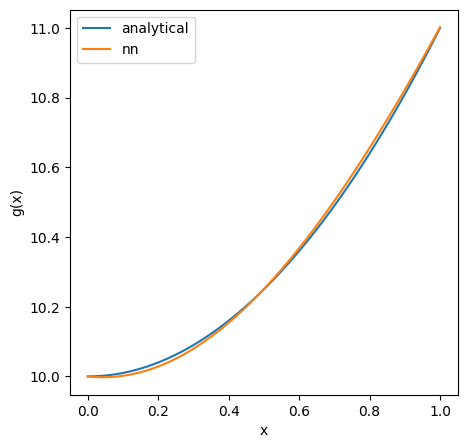

In [67]:
    # Plot the results
    plt.figure(figsize=(5,5))

    plt.plot(x, res_analytical)
    plt.plot(x, res[0,:])
    plt.legend(['analytical','nn'])
    plt.xlabel('x')
    plt.ylabel('g(x)')
    plt.show()

In [74]:
print(g_trial(np.array([1.5]), P))
print(g_analytic(np.array([1.5])))

[[12.03120278]]
[12.25]


In [153]:
import torch, torch.nn as nn, torch.utils.data as data, torch.nn.functional as F
from torch.autograd import grad
import lightning as L
import numpy as np


class Learner(L.LightningModule):
    def __init__(self, model, init_condition):
        super().__init__()
        self.model = model
        self.init_condition = init_condition

    def forward(self, x):
        return self.model(x);
    
    def g(self, x, g_trial, gamma = 2):
        return 2 * x
    
    def training_step(self, batch, batch_idx):
        x, _ = batch
        x.requires_grad = True

        g_trial = self.init_condition + x * self.model(x)
        trial_sol = self.g(x, g_trial)

        g_trial.backward(torch.Tensor([[1], [1], [1], [1], [1]]))
        d_g_trial = x.grad
        #print(d_g_trial)
        #print(trial_sol)
        
        loss = nn.MSELoss()(d_g_trial, trial_sol)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        #print(loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=.0001)
        return optimizer

In [154]:
class Dataset(data.Dataset):

    def __init__(self, init, end, n):

        self.n = n
        self.x = torch.linspace(init, end, self.n)
        #self.y = 10*np.exp(2*x)
        self.y = 10 + x**2

    def __len__(self):

        return self.n

    def __getitem__(self, idx):

        x = self.x[idx, np.newaxis]
        y = self.y[idx, np.newaxis]

        return torch.Tensor(x), torch.Tensor(y)

In [155]:
'''
net = nn.Sequential(
        nn.Linear(1, 20),
        nn.ELU(),
        nn.Linear(20, 50),
        nn.ELU(),
        nn.Linear(50, 20),
        nn.ELU(),
        nn.Linear(20, 1)
    )
'''

net = nn.Sequential(
        nn.Linear(1, 10),
        nn.Sigmoid(),
        nn.Linear(10, 1)
    )

In [156]:
train = Dataset(0, 1, 50)

trainer = L.Trainer(logger=False, max_epochs=1000)
learner = Learner(net, 10)
trainer.fit(learner, data.DataLoader(train, batch_size=5))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 31    
-------------------------------------
31        Trainable params
0         Non-trainable params
31        Total params
0.000     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

ValueError: x and y must be the same size

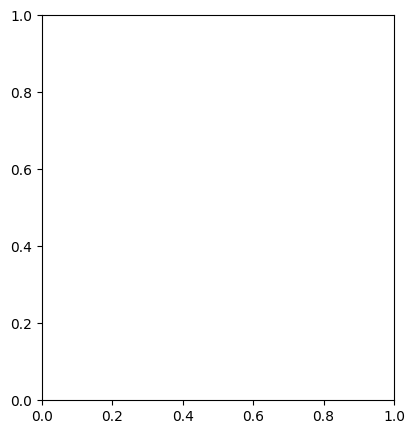

In [160]:
import matplotlib.pyplot as plt

y = learner.model.forward(train.x.view(50, 1))
y = y.detach().cpu()
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.scatter(train.x, 10 + train.x * y, color='black')

ax1 = fig.add_subplot(122)
ax1.scatter(train.x, train.y)